In [1]:
import numpy as np
import pandas as pd
import json
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Input, Model
from keras.layers import Dense, Dropout, Flatten, add
import keras

In [3]:
from keras.utils import to_categorical, Sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop,Adam

In [4]:
BASE_DIR = "../input/cassava-leaf-disease-classification/"

os.listdir(BASE_DIR)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [5]:
train_data = pd.read_csv(BASE_DIR+'train.csv')
samp_subm = pd.read_csv(BASE_DIR+'sample_submission.csv')

print(train_data)

             image_id  label
0      1000015157.jpg      0
1      1000201771.jpg      3
2       100042118.jpg      1
3      1000723321.jpg      1
4      1000812911.jpg      3
...               ...    ...
21392   999068805.jpg      3
21393   999329392.jpg      3
21394   999474432.jpg      1
21395   999616605.jpg      4
21396   999998473.jpg      4

[21397 rows x 2 columns]


In [6]:
print('number of train data:', len(train_data))
print('number of train images:', len(os.listdir(BASE_DIR+'train_images/')))
print('number of test images:', len(os.listdir(BASE_DIR+'test_images/')))

number of train data: 21397
number of train images: 21397
number of test images: 1


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
train_df['label'] = train_df['label'].astype(str)

batch_size=16
input_size = (300, 300)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split = 0.1,
    rotation_range=360,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    #channel_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None,
    preprocessing_function=None,
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(BASE_DIR, 'train_images'),
    x_col="image_id",
    y_col="label",
    batch_size=batch_size,
    target_size=input_size,
    class_mode="sparse", 
    subset = "training"
)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.1)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(BASE_DIR, 'train_images'),
    x_col="image_id",
    y_col="label",
    batch_size=batch_size,
    target_size=input_size ,
    class_mode="sparse", 
    subset="validation")

Found 19258 validated image filenames belonging to 5 classes.
Found 2139 validated image filenames belonging to 5 classes.


In [8]:
BATCH_SIZE=16
STEPS_PER_EPOCH = len(train_df)*0.9 // BATCH_SIZE
VALIDATION_STEPS = len(train_df)*0.1 // BATCH_SIZE
print(STEPS_PER_EPOCH)
print(VALIDATION_STEPS)

1203.0
133.0


In [9]:
from keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import EfficientNetB3 
import tensorflow as tf

In [10]:
xception_weights_dir = '../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_xcep = Xception(weights = xception_weights_dir, include_top = False, input_shape = (300,300,3))
base_xcep.trainable  = False

vgg16_weights_dir = "../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_vgg16 = VGG16(weights = vgg16_weights_dir, include_top = False, input_shape = (300,300,3))
base_vgg16.trainable = False

resnet50_weights_dir =  "../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_resnet50 = ResNet50(weights = resnet50_weights_dir, include_top = False, input_shape = (300,300,3))
base_resnet50.trainable = False

efficientNetB3_dir = "../input/tfkerasefficientnetimagenetnotop/efficientnetb3_notop.h5"
base_efficientNetB3 = EfficientNetB3(weights = efficientNetB3_dir, include_top = False, input_shape = (300, 300, 3))


In [11]:
def create_base_model(base_model):
    
    inputs = Input(shape = (300,300,3))
    
    base_out = base_model(inputs)
    
    base_out = Flatten()(base_out)
    
    base_out = Dropout(0.3)(base_out)
    
    base_out = Dense(1024, activation = 'relu')(base_out)
    
    model = Model(inputs = inputs, outputs = base_out)
    
    return model

xcep_base = create_base_model(base_xcep)
vgg16_base = create_base_model(base_vgg16)
resnet50_base = create_base_model(base_resnet50)
efficientNetB3_base = create_base_model(base_efficientNetB3)


def create_model(base1, base2, base3, base4):
    
    inputs = Input(shape = (300,300,3))
    
    base1_out = base1(inputs)
    base2_out = base2(inputs)
    base3_out = base3(inputs)
    base4_out = base4(inputs)
    base_out = add([base1_out, base2_out, base3_out, base4_out])
    
    outputs = Dense(512, activation = 'relu')(base_out)
    
    outputs = Dropout(0.2)(outputs)
    
    outputs = Dense(5, activation = 'softmax')(outputs)
    
    model = Model(inputs = inputs, outputs = outputs)
    
    model.summary()

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    return model
    
    
model = create_model(xcep_base, vgg16_base, resnet50_base, efficientNetB3_base)

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 1024)         230577704   input_9[0][0]                    
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 1024)         57183040    input_9[0][0]                    
__________________________________________________________________________________________________
functional_5 (Functional)       (None, 1024)         233303936   input_9[0][0]                    
_______________________________________________________________________________________

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
             EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [13]:
history = model.fit_generator(
    train_generator,
    validation_data = valid_generator,
    steps_per_epoch = len(train_df)*0.9//batch_size,
    validation_steps = len(train_df)*0.1//batch_size, 
    epochs = 20,
    verbose=1,
    callbacks = callbacks,
    
)

Epoch 1/20
1203/1203 [==============================] - 1110s 922ms/step - loss: 4.0523 - accuracy: 0.6612 - val_loss: 0.7125 - val_accuracy: 0.7773
Epoch 2/20
1203/1203 [==============================] - 1090s 906ms/step - loss: 0.7241 - accuracy: 0.7682 - val_loss: 0.6104 - val_accuracy: 0.8064
Epoch 3/20
1203/1203 [==============================] - 1109s 922ms/step - loss: 0.6069 - accuracy: 0.7952 - val_loss: 0.5401 - val_accuracy: 0.8163
Epoch 4/20
1203/1203 [==============================] - ETA: 0s - loss: 0.5614 - accuracy: 0.8128
Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1203/1203 [==============================] - 1019s 847ms/step - loss: 0.5614 - accuracy: 0.8128 - val_loss: 0.5454 - val_accuracy: 0.8191
Epoch 5/20
1203/1203 [==============================] - 1063s 884ms/step - loss: 0.4743 - accuracy: 0.8387 - val_loss: 0.4525 - val_accuracy: 0.8506
Epoch 6/20
1203/1203 [==============================] - ETA: 0s - loss: 0.4465 - accurac

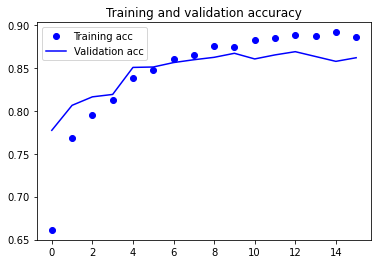

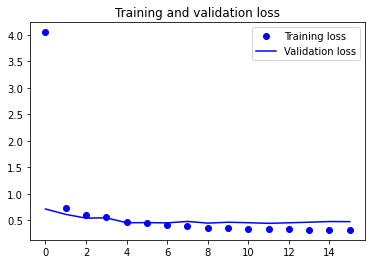

In [14]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
sample = "../input/cassava-leaf-disease-classification/sample_submission.csv"
sample_df = pd.read_csv(sample)
sample_df.head()

,image_id,label
0,2216849948.jpg,4


In [16]:
INPUT_PATH = "../input/cassava-leaf-disease-classification/"
test_images_path = INPUT_PATH+"test_images/"

In [17]:
import cv2
import tensorflow as tf
import numpy as np 
from matplotlib import pyplot as plt
from PIL import Image

In [18]:
predictions = []
for image_id in sample_df.image_id:
    img = Image.open(os.path.join(test_images_path+image_id))
    img = img.resize((300,300))
    img = np.expand_dims(img, axis=0)
   
    predictions.append(np.argmax(model.predict(img)))

sample_df["label"] = predictions

In [19]:
sample_df.to_csv("submission.csv", index = False)

得分：0.861